# Part1: Heatmap and Markercluster map

## 1. import all modules you need

In [9]:
import pandas as pd
import geojsonio
import json
import folium
import os
import matplotlib
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster

## 2. clean data

In [1]:
def read_Airbnb_data(datafile):
    import pandas as pd
    import numpy as np
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    #Add the fix_price function
    def fix_price(input_price):
        try:
            input_price = float(input_price)
        except:
            try:
                input_price = float(input_price[1:])
            except:
                return np.NaN
        return input_price
    
    #Read datafile
    df = pd.read_csv(datafile)
    df = df.loc[:,['price','id','name','room_type','accommodates','zipcode',
                                   'bathrooms','review_scores_rating','neighbourhood','neighbourhood_cleansed','guests_included','number_of_reviews','longitude','latitude']]
    
    #Fix zipcode
    df['zipcode'] = df['zipcode'].apply(fix_zip)
    df['price'] = df['price'].apply(fix_price)
    
    df.dropna(inplace=True)
    df = df[df['number_of_reviews']>0]
    
    return df
df = read_Airbnb_data('listings.csv')

/Users/apple/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## 3. calculate rental price per person per day

In [3]:
df['perprice'] = df['price']/df['accommodates']

## 4. calculate the average of each neighbourhood 

In [4]:
sizes = df.groupby('neighbourhood_cleansed').mean()['perprice']
sizes = pd.DataFrame(sizes)

#then find anormal data according to sizes and search it in Airbnb
#So delete it from datasets
df = df[df['id']!=20330081]

#calculate again
sizes = df.groupby('neighbourhood_cleansed').mean()['perprice']
sizes = pd.DataFrame(sizes)

## 5. make up with data neighbourhood which have no Airbnb house 

In [6]:
# get a list showing all neighbourhoods in New York City
df1 = pd.read_csv('neighbourhoods.csv')['neighbourhood']
neblist = list(df1)

# then use for loop add missing data, let value equal to 0
for i in neblist:
    if not i in sizes.index:
        sizes.loc[i] = 0

## 6. prepare the dataframe for heatmap

In [7]:
# reset index to prepare for heatmap        
sizes.reset_index(level=0, inplace=True)

## 7. draw a heatmap showing each neighbourhood's average rental per person per day

In [8]:
m = folium.Map(location = [40.7589,-73.9851],zoom_start=11)
m.choropleth(geo_data='neighbourhoods.geojson', data=sizes,
             columns=[ 'neighbourhood_cleansed','perprice'],
             key_on='feature.properties.neighbourhood',
             fill_color='RdYlGn', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of houseprice per price')
folium.LayerControl().add_to(m)

m.save(os.path.join('result', 'neighbourhood_perprice.html'))

## 8. draw a markercluster map showing the distribution of Airbnb houses in NYC 

In [10]:
m2 = folium.Map(location = [40.7589,-73.9851],zoom_start=11)

# get all Airbnb houses' location
lons = df['longitude']
lats = df['latitude']

# initial the graph
marker_cluster = MarkerCluster(
    name='house distribution',
    overlay=True,
    control=False,
    icon_create_function=None
)

# use for loop add each house location in the map
for k in range(len(lons)):
    location = lats.iloc[k], lons.iloc[k]
    marker = folium.Marker(location=location)
    popup = 'lon:{}<br>lat:{}'.format(location[1], location[0])
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

# save it
marker_cluster.add_to(m2)

folium.LayerControl().add_to(m2)

m2.save(os.path.join('result', 'house_distribution.html'))

# Part2: Scartter chart 

<li>We want to draw a scartter chart to show the difference between avarage price to lease house and average price to buy the house in each neighbourhood.

## 1. clean data and calculate average price to buy houses in each neighbourhood

In [11]:
def cleandata(file):
    #read file
    df1 = pd.read_csv(file)
    
    #get columns we need
    df1 = df1[['NEIGHBORHOOD','GROSS SQUARE FEET',' SALE PRICE ']]
    
    # deal with column GROSS SQUARE FEET and SALE PRICE
    import re
    for i in df1.index:
        x = df1.loc[i]['GROSS SQUARE FEET']
        if type(x) == str:
            if ',' in x:
                x = x.split(',')
                df1.loc[i]['GROSS SQUARE FEET'] = int(x[0])*1000 + int(x[1])
            else:
                df1.loc[i]['GROSS SQUARE FEET'] = int(x)
        y = df1.loc[i][' SALE PRICE ']
        pattern = r'[0-9]+'
        y = re.findall(pattern,y)
        if not y:
            df1.loc[i][' SALE PRICE '] = 0
        else:
            if len(y) == 1:
                df1.loc[i][' SALE PRICE '] = int(y[0])
            else:
                l = len(y)-1
                z = 0
                for j in range(l):
                    z = z + int(y[j]) * (1000**(l-j))
                    df1.loc[i][' SALE PRICE '] = z
    #change type
    df1['GROSS SQUARE FEET'] = df1['GROSS SQUARE FEET'].astype(int)
    df1[' SALE PRICE '] = df1[' SALE PRICE '].astype(int)
    df1['NEIGHBORHOOD'] = df1['NEIGHBORHOOD'].astype(str)
    
    #delete NAN
    df1 = df1[(df1['GROSS SQUARE FEET'] != 0)]
    df1 = df1[(df1[' SALE PRICE '] != 0)]
    
    #get the price per square feet
    df1['price'] = df1[' SALE PRICE ']/df1['GROSS SQUARE FEET']
    
    #calculate the average price for each neighbourhood
    df1 = df1.groupby('NEIGHBORHOOD').mean()
    
    return df1

## 2. read and clean data from 5 files, and merge them into  a complete file 

In [12]:
df1 = cleandata('rollingsales_brooklyn.csv')
df2 = cleandata('rollingsales_bronx.csv')
df3 = cleandata('rollingsales_manhattan.csv')
df4 = cleandata('rollingsales_queens.csv')
df5 = cleandata('rollingsales_statenisland.csv')
df = pd.concat( [df1,df2,df3,df4,df5], axis=0 )

## 3. get the average price to buy the house in each neighbourhood

In [13]:
df = df[['price']]
df.reset_index(level=0, inplace=True)

## 4. get the average price to lease the house in each neighbourhood

In [15]:
# calculate the average price to leas
dfre = read_Airbnb_data('listings.csv')
dfre['perprice'] = dfre['price']/dfre['accommodates']
sizes = dfre.groupby('neighbourhood_cleansed').mean()['perprice']
sizes = pd.DataFrame(sizes)

df_ = pd.read_csv('neighbourhoods.csv')['neighbourhood']
neblist = list(df_)
for i in neblist:
    if not i in sizes.index:
        sizes.loc[i] = 0
        
sizes.reset_index(level=0, inplace=True)

/Users/apple/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## 5. make the index same and merge two dataframe

In [16]:
sizes.columns = ['NEIGHBORHOOD','perprice']
sizes['NEIGHBORHOOD'] = sizes['NEIGHBORHOOD'].apply(lambda x: x.lower())
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].apply(lambda x: x.lower()) 
result = pd.merge(sizes,df, how='left', on='NEIGHBORHOOD')

## 6. deal with NaN and 0 

In [17]:
result.dropna(inplace=True)
result = result[(result['perprice'] != 0)]

## 7.  remove the useless extreme values and draw the scatter chart

In [18]:
result = result[(result['NEIGHBORHOOD'] != 'chelsea')]
result = result[(result['NEIGHBORHOOD'] != 'tribeca')]

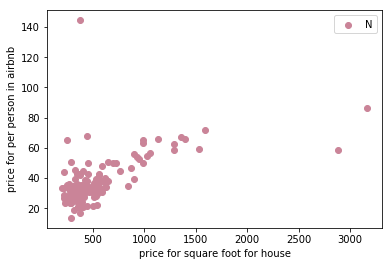

In [19]:
y = result['perprice']
x = result['price']
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
plt.xlabel('price for square foot for house')
plt.ylabel('price for per person in airbnb')
ax1.scatter(x,y,c = '#ca8498',marker = 'o')
plt.legend('N')
plt.show()

## 8. find the neighbourhood name we need 

In [20]:
result[(result['perprice'] > 60) & (result['price'] <600)]

,NEIGHBORHOOD,perprice,price
14,belle harbor,67.805556,448.281619
121,mariners harbor,65.083333,252.865445
166,riverdale,144.452381,380.356292
